The IRIS data set is made up of observations of the petal and sepal lenght and width for 150 flowers. This belong to three slightly different species: Setosa, Versicolour and Virginica. In this colab we use this simple data set to show an implementation of the EM algorithm for Gaussian Mixture Models from scratch.

In [ ]:
from sklearn.datasets import load_iris

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, adjusted_rand_score
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA

The Gaussian Mixture Model (GMM) is implemented as a class. This is initialized with three parameters: the number of gaussian components, a treshold value to signal convergence of the log-likelihood and a maximum number of iterations to avoid infinite loops.

The model is initialized with equal weights, random means and covariance matrices with unitary diagonal. In the E-step function responsabilities are calculated with the current parameters together with the log-likelihood value that is needed to check the convergence.
In the m-step weights, means and covariances are updating and precaution is taken to avoid singular matrices and near-singular matrices. This could happen for example if a cluster has very few points or if two features are perfectly collinear. Even a near-singular covariance matrix could mean numerical instability when calculating the inverse and create problems.

In the fit functions the steps are put together and the threshold and iteration limit applied. The predict function allow the use of the model for classification.

In [ ]:
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-4):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol

    def initialize(self, X):
        n_samples, n_features = X.shape  #X is the input data-set
        self.weights_ = np.ones(self.n_components) / self.n_components #The weights are initiliazed as equal
        random_idx = np.random.choice(n_samples, self.n_components, replace=False)
        self.means_ = X[random_idx]  #The 3 means are chosen randomly between 0 and n_samples
        self.covariances_ = np.array([np.eye(n_features) for _ in range(self.n_components)]) # "1-diagonal" covariance matrix for each gaussian

    def multivariate_normal(self, X, mean, cov):
        n_features = X.shape[1]  #features = dimensions
        cov_inv = np.linalg.inv(cov)  #Inverse covariance
        cov_det = np.linalg.det(cov)  #Covariance determinant
        denominator = np.sqrt((2 * np.pi) ** n_features * cov_det)
        diffs = X - mean
        exponent = -0.5 * np.sum(np.dot(diffs, cov_inv) * diffs, axis=1)
        return np.exp(exponent) / denominator  #Final formula for the multivariate normal

    def e_step(self, X):  #Calculating the responsabilities with the given parameters
        n_samples = X.shape[0]
        self.resp = np.zeros((n_samples, self.n_components))  #resps for each point and each component
        for k in range(self.n_components):
            self.resp[:, k] = self.weights_[k] * self.multivariate_normal(X, self.means_[k], self.covariances_[k])
        sum_resp = self.resp.sum(axis=1, keepdims=True)
        self.resp /= sum_resp  #Matrix of responsabilities
        return np.sum(np.log(sum_resp))  #Returns log-likelihood to check the convergence

    def m_step(self, X):  #Updating the parameters given the new responsabilities
        n_samples = X.shape[0]
        resp_sum = self.resp.sum(axis=0)
        self.weights_ = resp_sum / n_samples  #Updating the weights
        for k in range(self.n_components):
            resp_k = self.resp[:, k]
            self.means_[k] = np.sum(resp_k[:, np.newaxis] * X, axis=0) / resp_sum[k]  #Updating means
            diff = X - self.means_[k]
            self.covariances_[k] = (resp_k[:, np.newaxis, np.newaxis] *  #Updating covariance matrices
                                   diff[:, :, np.newaxis] * diff[:, np.newaxis, :]).sum(axis=0) / resp_sum[k]
            self.covariances_[k] += 1e-6 * np.eye(X.shape[1])  #Adding a small value to the diagonal to avoid singular matrices

    def fit(self, X):
        self.initialize(X)  #Initializing the parameters
        prev_log_likelihood = None
        for _ in range(self.max_iter):  # Maximum iterations limit
            log_likelihood = self.e_step(X)  #Retrieving the log-likelihood (E-step)
            if prev_log_likelihood is not None and abs(log_likelihood - prev_log_likelihood) < self.tol: #Checking the treshold
                break
            prev_log_likelihood = log_likelihood
            self.m_step(X) #M-step

    def predict(self, X): #Predict function for use as a classifier
        resp = np.zeros((X.shape[0], self.n_components))
        for k in range(self.n_components):
            resp[:, k] = self.weights_[k] * self.multivariate_normal(X, self.means_[k], self.covariances_[k])
        return np.argmax(resp, axis=1) #Assigns the point to the component with the higher responsability

In [ ]:
#Function to align the labels of the ground truth and the observations
def align_labels(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    row_ind, col_ind = linear_sum_assignment(-cm)    #We need a way to understand which component represents a certain flower species
    mapping = dict(zip(col_ind, row_ind))            #The hungarian algorithm is applied to find the best alignment
    return np.array([mapping[pred] for pred in y_pred])

The model so defined was than applied to classify the samples of the iris data set to show that it works as it should.

In [ ]:
#Application to the iris data set
data = load_iris()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Fit GMM
gmm = GMM(n_components=3, max_iter=100)
gmm.fit(X_scaled)

y_pred = gmm.predict(X_scaled)
y_pred_aligned = align_labels(y, y_pred)

#Performance metrics
accuracy = accuracy_score(y, y_pred_aligned)
ari = adjusted_rand_score(y, y_pred)
cm = confusion_matrix(y, y_pred_aligned)

print(f"Accuracy: {accuracy:.4f}")
print(f"Adjusted Rand Index: {ari:.4f}")
print("Confusion Matrix:")
print(cm)

Accuracy: 0.9667
Adjusted Rand Index: 0.9039
Confusion Matrix:
[[50  0  0]
 [ 0 45  5]
 [ 0  0 50]]


In [ ]:
#Function to plot the results using PCA to obtain a 2D representation

#First we transform the whole data set using PCA and then we project the means and the covariances of each gaussian component
def plot_gmm_results(X, y, y_pred, gmm, pca):
    X_pca = pca.transform(X) #Projecting the data
    means_pca = pca.transform(gmm.means_) #Projecting the means
    covs_pca = np.zeros((gmm.n_components, 2, 2))
    for k in range(gmm.n_components):
        covs_pca[k] = pca.components_ @ gmm.covariances_[k] @ pca.components_.T #projecting the covariance matrices in the first 2 PCs

    plt.figure(figsize=(14, 6))

    #True labels plot
    plt.subplot(121)
    for species in np.unique(y):
        plt.scatter(X_pca[y == species, 0], X_pca[y == species, 1],
                    label=data.target_names[species], s=30)
    plt.title('True Species')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.legend()

    #GMM clusters with ellipses
    plt.subplot(122)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', s=30)
    plt.colorbar(scatter, label='Cluster')

    #Ellipsis
    for k in range(gmm.n_components):
        mean = means_pca[k] #Center of the ellipsis
        cov = covs_pca[k]

        eigvals, eigvecs = np.linalg.eigh(cov)  #Extracting eigenvalues and eigenvectors for the ellipsis
        order = eigvals.argsort()[::-1]
        eigvals, eigvecs = eigvals[order], eigvecs[:, order]

        #Ellipsis parameters
        angle = np.degrees(np.arctan2(eigvecs[1, 0], eigvecs[0, 0]))
        width, height = 2 * 2 * np.sqrt(eigvals)  #The eigenvalues are the variance in the two eigendirections, we keep 2 standard deviations (2*2 = diameter)

        plt.plot(mean[0], mean[1], 'rx', markersize=10, mew=2)
        ellipse = Ellipse(mean, width, height, angle=angle,
                          edgecolor='r', fc='None', lw=2)
        plt.gca().add_patch(ellipse)

    plt.title('GMM Clusters')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')

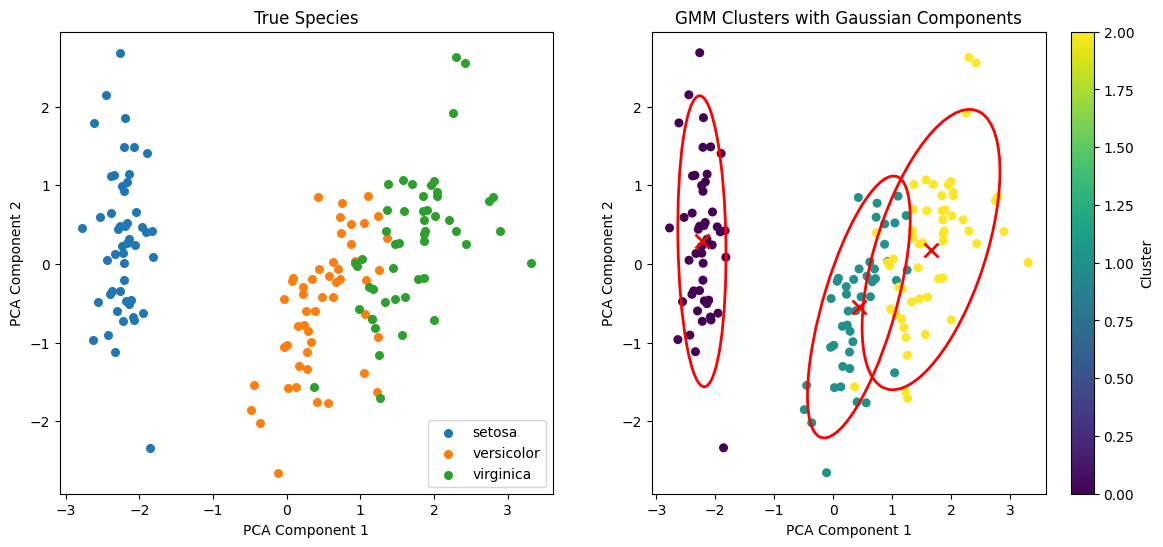

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit(X_scaled)

plot_gmm_results(X_scaled, y, y_pred_aligned, gmm, pca)
plt.show()